In [1]:
import numpy as np

Implementation of physical model:

$X_{k+1} = A \cdot X_k + B \cdot U_k$

$Q$ — noise covariance matrix

In [427]:
class Phys_model: 
    def __init__(self, A=None, B=None, C=None):
        self.__A = A
        self.__B = B
        self.__C = C
    
    def get_next_step(self, x_k, u_k):
        return (self.A.dot(x_k) + self.B.dot(u_k), C.dot(u_k))  
    
    #getters and setters
    @property
    def A(self):
        return self.__A
    
    @property
    def B(self):
        return self.__B
    
    @property
    def C(self):
        return self.__C


In [428]:
def print_debug(*args):
    str_to_print = ""
    for i, arg in enumerate(args):
        str_to_print = str_to_print + "Arg{num}: {arg}\t".format(num=i+1, arg=arg)
    print(str_to_print)

In [491]:
class KalmanFilter: 
    def __init__(self, phys_model, Q, H, P, K, R, z):
        self.__phys_model = phys_model
        self.__Q = Q
        self.__H = H
        self.__P = P
        self.__K = K
        self.__R = K
        self.__z = z
        
    def project_error_covariance(self, P):
        A = self.phys_model.A
        return A.dot(P).dot(A.T) + Q
    
    def error_covariance_update(self, P, K, H):
        E = np.eye(K.shape[0])
        return (E - K.dot(H)).dot(P)
    
    def compute_kalman_gain(self, P, H, R):
        tmp = (H.dot(P).dot(H.T) + R)
        try: 
            tmp = H.dot(P).dot(H.T) + R
            tmp = np.linalg.inv(tmp)
        except np.linalg.linalg.LinAlgError:
            tmp = np.zeros(tmp.shape)
        return P.dot(H.T).dot(tmp)
    
    
    def do_filtration(self, n_steps, xk_initial, uk_initial):
        xk_opt = xk_initial
        uk = uk_initial
        
        res = [xk_opt]
        
        for i in range(n_steps):
            (xk, uk) = self.phys_model.get_next_step(xk_opt, uk)
            p = self.project_error_covariance(self.P)
            
            K = self.compute_kalman_gain(self.P, self.H, self.R)
            xk_opt = xk + K.dot(self.z[i] - self.H.dot(xk))
            res.append(xk_opt)
            self.P = self.error_covariance_update(p, K, self.H)
        return np.array(res)
    
    #getters and setters
    @property
    def phys_model(self):
        return self.__phys_model
    
    @property
    def Q(self):
        return self.__Q
    
    @property
    def P(self):
        return self.__P
    
    @P.setter
    def P(self, P):
        self.__P = P
    
    @property
    def K(self):
        return self.__K
    
    @property
    def H(self):
        return self.__H
    
    @property
    def z(self):
        return self.__z
    
    @property
    def R(self):
        return self.__R

In [475]:
A = np.array([[1]])
B = np.array([[1]])
C = np.array([[1]])

model = Phys_model(A, B, C)

In [476]:
xk = np.array([[1]])
uk = np.array([[1]])
observations = [xk]
for i in range(100 - 1):
    (xk, uk) = model.get_next_step(xk, uk)
    observations.append(xk)

observations = np.array(observations)
observations_with_noise = observations + np.random.normal(0, 3, 100).reshape(100, 1, 1)

In [477]:
Q = np.array([[0.1]])
H = np.array([[1]])
P = np.array([[1]])
K = np.array([[2]])
R = np.array([[2]])
z = observations_with_noise

filter = KalmanFilter(model, Q, H, P, K, R, z)

In [234]:
xk = np.array([[1]])
uk = np.array([[1]])

res = filter.do_filtration(50, xk, uk)

In [235]:
obs_reshaped = observations.reshape(observations.shape[0],)
obs_wn_reshaped = observations_with_noise.reshape(observations_with_noise.shape[0],)
res_reshaped = res.reshape(res.shape[0],)

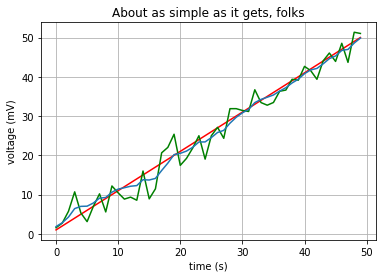

In [236]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

t = np.arange(0.0, 50, 1)

plt.plot(t, obs_reshaped[:50], 'r')
plt.plot(t, obs_wn_reshaped[:50], 'g')
plt.plot(t, res_reshaped[1:51])
plt.xlabel('time (s)')
plt.ylabel('voltage (mV)')
plt.title('About as simple as it gets, folks')
plt.grid(True)
plt.savefig("test.png")
plt.show()

### Model 2

In [492]:
A = np.array([[0.3, 1.1], [0.9, 0]])
B = np.array([[0], [0]])
C = np.array([[0]])

model = Phys_model(A, B, C)

In [493]:
xk = np.array([[1],[0.3]])
uk = np.array([[0]])
observations = [xk]
for i in range(100 - 1):
    (xk, uk) = model.get_next_step(xk, uk)
    observations.append(xk)

observations = np.array(observations)
cov = np.array([[1, 0],
                [0, 2]])
observations_with_noise = observations + np.random.multivariate_normal([0, 0], cov, 100).reshape(100, 2, 1)

In [499]:
observations.shape

(100, 2, 1)

In [504]:
R = np.array([[1, 0],
             [0, 1.7]])
H = np.array([[1, 0],
              [0, 1]])
P = np.array([[1, 0],
              [0, 1]])
K = np.array([[1, 0],
              [0, 1]])
Q = np.array([[1, 0],
              [0, 1.1]])
z = observations_with_noise

filter = KalmanFilter(model, Q, H, P, K, R, z)

In [505]:
xk = np.array([[1],[0.3]])
uk = np.array([[0]])

re = filter.do_filtration(30, xk, uk)

array([[ 2.22348626],
       [ 0.58621158]])

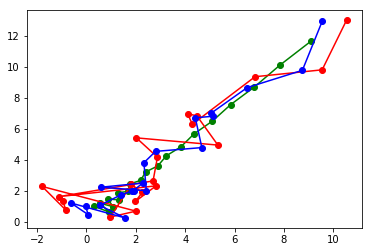

In [508]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.plot(observations[:20, 1], observations[:20, 0], 'go-')
plt.plot(observations_with_noise[:20, 1], observations_with_noise[:20, 0], 'ro-')
plt.plot(re[1:21, 1], re[1:21, 0], 'bo-')
plt.show()